In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

class Darts():

    def __init__(self):
        self.radii = [250, 225, 215, 170, 160, 100, 90, 25, 15]
        self.img = np.ones((600, 600), dtype=np.uint8)*255
        self.points = np.zeros(self.img.shape)
        self.center = (len(self.img)//2, len(self.img)//2)
        self.numbers = [13, 6, 10, 15, 2, 17, 3, 19, 7, 16, 8, 11, 14, 9, 12, 5, 20, 1, 18, 4]
        self.numbers_score = [6, 10, 15, 2, 17, 3, 19, 7, 16, 8, 11, 14, 9, 12, 5, 20, 1, 18, 4, 13]
        self.draw_new()

    def draw_new(self):
        self.number_angles = []

        for radius in self.radii:
            self.img = cv2.circle(self.img, self.center, radius, (0, 0, 0), 3)

        nsections = 20
        start_angl = -3.14/nsections
        delta_angl = 2*3.14/nsections
        for i in range(nsections+1):
            r = self.radii[1]
            angle = i*delta_angl + start_angl
            self.number_angles.append(angle)
            otherp = (int(math.cos(angle)*r), int(math.sin(angle)*r))
            otherp = (otherp[0]+self.center[0], otherp[1]+self.center[1])
            self.img = cv2.line(self.img, self.center, otherp, (0, 255, 0), 2)

        r = self.radii[0] + 30

        for num, angle in zip(self.numbers, self.number_angles[:-1]):
            angle += start_angl
            self._put_numbers(num, r, angle)
            # pass


        return self.img

    def show(self):
        plt.imshow(self.img.astype(np.float))

    def get_score(self, x, y):
        r, angle = self._to_polar(x, y)
        if angle < 0:
            angle += 2*3.14
        mult = 1
        score = 0
        if r >= self.radii[1]:
            mult = 0
        elif self.radii[-7] >= r >= self.radii[-6]:
            mult = 2
        elif self.radii[-6] >= r >= self.radii[-5]:
            mult = 1
        elif self.radii[-5] >= r >= self.radii[-4]:
            mult = 3
        elif self.radii[-4] >= r >= self.radii[-3]:
            mult = 1
        elif self.radii[-3] >= r >= self.radii[-2]:
            mult = 4
        elif self.radii[-2] >= r >= self.radii[-1]:
            return 25
        else:
            return 50

        for num, frst, secnd in zip(self.numbers_score, self.number_angles[:-1], self.number_angles[1:]):
            if frst < angle < secnd:
                score = num
                break
        return num*mult
        

    def _to_polar(self, x, y):
        r = math.sqrt((x-self.center[0])**2 + (y-self.center[1])**2)
        angle = math.atan2(y-self.center[1], x-self.center[0])
        return r, angle

    def _put_numbers(self, n, r, angle):
        text = str(n)
        font = cv2.FONT_HERSHEY_SIMPLEX 
        x, y = self._cart2pol(r, angle)
        orig = (int(x)+self.center[0]-20, int(y)+self.center[1]+10)
        fontScale = 1
        color = (0, 0, 250)   
        thickness = 2   
        # print(orig, int(x), int(y), text, self.center)
        self.img = cv2.putText(self.img, text, orig, font, fontScale,  
                        color, thickness, cv2.LINE_AA, False) 

    def _cart2pol(self, r, angle):
        x = math.cos(angle)*r
        y = math.sin(angle)*r
        return x, y

    def draw_dart(self, x, y, size=20, color=(0, 255, 0), thickness=10):
        x, y = int(x), int(y)
        p1 = (x, y-size)
        p2 = (x, y+size)
        p3 = (x-size, y)
        p4 = (x+size, y)
        self.img = cv2.line(self.img, p1, p2, color, thickness)
        self.img = cv2.line(self.img, p3, p4, color, thickness)

    def draw_gaussian(self, mu, cov, x0=None, y0=None, ndraw=10):
        if x0 is None:
            x0 = self.center[0]
        if y0 is None:
            y0 = self.center[1]
        xt, yt = np.random.multivariate_normal(mu, cov, ndraw).T
        for xthrow, ythrow in zip(xt, yt):
            self.draw_dart(xthrow, ythrow, size=10, thickness=5)

    def get_best(self, cov, nthrow=10, xstride=1, ystride=1):
        maxpoints = float('-inf')
        coor = (-1, -1)
        for x in range(50, 550, xstride):
            print(int(x/550*100), "%", end='\r')
            for y in range(50, 550, ystride):
                mean = [x, y]
                xt, yt = np.random.multivariate_normal(mean, cov, nthrow).T
                points = 0
                for xthrow, ythrow in zip(xt, yt):
                    points += self.get_score(xthrow, ythrow)
                self.points[x, y] = points
                # print(x, y, points, len(xt), xt)
                if points > maxpoints:
                    maxpoints = points
                    coor = (x, -y)

        return self.points, maxpoints, coor

    def draw_points(self):
        plt.imshow(self.points)


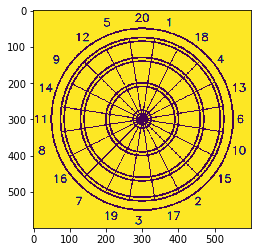

In [28]:
darts = Darts()
mu = [300, 300]
cov = [[1, 0], [0, 1]]
darts.draw_gaussian(mu, cov, ndraw=100)
darts.show()


In [19]:
darts = Darts()
# cov = [[1, 0], [0, 100]]
darts.get_best(cov, nthrow=4, xstride=1, ystride=1)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 320,
 (285, -203))

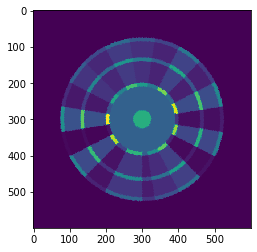

In [20]:
darts.draw_points()

12

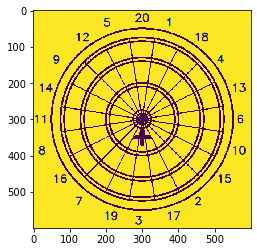

In [29]:
darts = Darts()
darts.draw_dart(300, 350)
darts.show()
darts.get_score(300, 350)

In [144]:
l = [13, 6, 10, 15, 2, 17, 3, 19, 7, 16, 8, 11, 14, 9, 12, 5, 20, 1, 18, 4]
for i in range(len(l)):
    r = (l[i]+l[(i+1)%len(l)]+l[(i-1)%len(l)])/3
    print(l[i], r)

13 7.666666666666667
6 9.666666666666666
10 10.333333333333334
15 9.0
2 11.333333333333334
17 7.333333333333333
3 13.0
19 9.666666666666666
7 14.0
16 10.333333333333334
8 11.666666666666666
11 11.0
14 11.333333333333334
9 11.666666666666666
12 8.666666666666666
5 12.333333333333334
20 8.666666666666666
1 13.0
18 7.666666666666667
4 11.666666666666666
